In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import seaborn as sns
import pandas as pd
import wandb

pd.set_option('display.max_columns', None)

In [3]:
api = wandb.Api()
entity, project = "invariance-learners", "aistats2024"  # set to your entity and project 
runs = api.runs(entity + "/" + project)

In [4]:
summary_list, config_list, name_list, tags, ids, states = [], [], [], [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    tags.append(run.tags)

    ids.append(run.id)

    states.append(run.state)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "tags": tags,
    "id": ids,
    "state": states
    })

runs_df

,summary,config,name,tags,id,state
0,"{'train/loss': 469.84234619140625, 'valid/elbo...","{'seed': 0, 'angle': 360, 'model': {'X_given_Z...",daily-morning-129,"[angle_sweep, mnist, num_trn_sweep, vae]",wexe9byf,finished
1,"{'recon': {'_type': 'image-file', 'width': 400...","{'seed': 0, 'angle': 360, 'model': {'X_given_Z...",still-smoke-127,"[angle_sweep, mnist, num_trn_sweep, vae]",8m9w5y0z,finished
2,"{'_step': 10000, 'recon': {'path': 'media/imag...","{'seed': 0, 'angle': 360, 'model': {'X_given_Z...",fast-morning-128,"[angle_sweep, mnist, num_trn_sweep, vae]",7hvvzqzl,finished
3,"{'valid/loss': 469.7499694824219, 'valid/z_kld...","{'seed': 0, 'angle': 360, 'model': {'X_given_Z...",fallen-fire-126,"[angle_sweep, mnist, num_trn_sweep, vae]",7fhpcwn3,finished
4,"{'recon': {'size': 64237, '_type': 'image-file...","{'seed': 0, 'angle': 360, 'model': {'X_given_Z...",kind-water-125,"[angle_sweep, mnist, num_trn_sweep, vae]",b70y9qzy,finished
...,...,...,...,...,...,...
99,"{'sample': {'size': 44618, '_type': 'image-fil...","{'seed': 0, 'angle': 45, 'model': {'X_given_Z'...",bumbling-darkness-30,"[angle_sweep, mnist, num_trn_sweep, vae]",9306osfa,finished
100,"{'recon': {'_type': 'image-file', 'width': 400...","{'seed': 0, 'angle': 0, 'model': {'X_given_Z':...",glad-surf-29,"[angle_sweep, mnist, num_trn_sweep, vae]",ldljb6hv,finished
101,{'sample': {'sha256': '5e4888d7360650247c08743...,"{'seed': 0, 'angle': 0, 'model': {'X_given_Z':...",fanciful-rain-27,"[angle_sweep, mnist, num_trn_sweep, vae]",uxkzia46,finished
102,"{'train/iwlb': None, 'valid/elbo': -2882.72119...","{'seed': 0, 'angle': 45, 'model': {'X_given_Z'...",fallen-pyramid-27,"[angle_sweep, mnist, num_trn_sweep, vae]",2h1s5xnm,finished


In [5]:
df_expanded = runs_df.join(pd.json_normalize(runs_df['summary'], record_prefix='summary.').add_prefix('summary.')).drop('summary', axis='columns')
df_expanded = df_expanded.join(pd.json_normalize(runs_df['config'], record_prefix='config').add_prefix('config.')).drop('config', axis='columns')

df_expanded.columns

Index(['name', 'tags', 'id', 'state', 'summary.train/loss',
       'summary.valid/elbo', 'summary.valid/loss', 'summary.train/ll',
       'summary._timestamp', 'summary.train/z_kld', 'summary.train/iwlb',
       'summary.valid/ll', 'summary.train/elbo', 'summary.valid/z_kld',
       'summary.lr', 'summary.β', 'summary._step', 'summary._runtime',
       'summary.valid/iwlb', 'summary.recon.sha256', 'summary.recon.path',
       'summary.recon.size', 'summary.recon._type', 'summary.recon.width',
       'summary.recon.format', 'summary.recon.height',
       'summary._wandb.runtime', 'summary.sample.path', 'summary.sample.size',
       'summary.sample._type', 'summary.sample.width', 'summary.sample.format',
       'summary.sample.height', 'summary.sample.sha256', 'config.seed',
       'config.angle', 'config.steps', 'config.dataset', 'config.init_lr',
       'config.num_trn', 'config.num_val', 'config.pp_eval', 'config.shuffle',
       'config.pp_train', 'config.run_iwlb', 'config.eval_freq

In [6]:
# take only completed runs
df_filtered = df_expanded[df_expanded['state'] == 'finished']

# take only runs with certain tags
tags_to_keep = ['angle_sweep', 'num_trn_sweep', 'mnist', 'vae']
df_filtered = df_filtered[df_filtered['tags'].apply(lambda x: all(tag in x for tag in tags_to_keep))]

# take only runs without certain tags
# tags_to_remove = ['test', 'hidden', 'ssilvae']
# df_filtered = df_filtered[~df_filtered['tags'].apply(lambda x: any(tag in x for tag in tags_to_remove))]

df_filtered

,name,tags,id,state,summary.train/loss,summary.valid/elbo,summary.valid/loss,summary.train/ll,summary._timestamp,summary.train/z_kld,summary.train/iwlb,summary.valid/ll,summary.train/elbo,summary.valid/z_kld,summary.lr,summary.β,summary._step,summary._runtime,summary.valid/iwlb,summary.recon.sha256,summary.recon.path,summary.recon.size,summary.recon._type,summary.recon.width,summary.recon.format,summary.recon.height,summary._wandb.runtime,summary.sample.path,summary.sample.size,summary.sample._type,summary.sample.width,summary.sample.format,summary.sample.height,summary.sample.sha256,config.seed,config.angle,config.steps,config.dataset,config.init_lr,config.num_trn,config.num_val,config.pp_eval,config.shuffle,config.pp_train,config.run_iwlb,config.eval_freq,config.plot_freq,config.val_split,config.batch_size,config.model_name,config.train_split,config.peak_lr_mult,config.warmup_steps,config.final_lr_mult,config.batch_size_eval,config.iwlb_num_samples,config.shuffle_buffer_size,config.repeat_after_batching,config.β_schedule_init_value,config.β_schedule_final_value,config.model.X_given_Z.conv_dims,config.model.X_given_Z.dense_dims,config.model.X_given_Z.max_2strides,config.model.Z_given_X.conv_dims,config.model.Z_given_X.dense_dims,config.model.Z_given_X.max_2strides,config.model.latent_dim
0,daily-morning-129,"[angle_sweep, mnist, num_trn_sweep, vae]",wexe9byf,finished,469.842346,-469.694031,469.694031,-445.836426,1.696460e+09,23.987280,NaN,-445.580414,-469.842346,24.113577,0.0001,1.0,3000.0,967.079483,-462.563568,f72e65900facd2b50de66ad390af89eb34f7e216b578ee...,media/images/recon_2999_f72e65900facd2b50de6.png,62455.0,image-file,4000.0,png,400.0,965.0,media/images/sample_2999_fec13f49217545fb4155.png,57796.0,image-file,4000.0,png,200.0,fec13f49217545fb4155cb2cf8d11f8180e412978bc82b...,0,360,3000,MNIST,0.0001,50000,10000,"value_range(-1, 1)|random_rotate(-360, 360, fi...",preprocessed,"value_range(-1, 1)|random_rotate(-360, 360, fi...",True,0.01,0.1,train[:10000],512,VAE,train[10000:60000],3,300,1,64,100,50000,True,10,1,"[256, 128, 64]",[256],2,"[64, 128, 256]",[256],2,16
1,still-smoke-127,"[angle_sweep, mnist, num_trn_sweep, vae]",8m9w5y0z,finished,690.402527,-690.813782,690.813782,-675.998108,1.696460e+09,14.392095,NaN,-676.259644,-690.402527,14.554111,0.0001,1.0,1000.0,846.511122,-685.000549,98d298cb6e691c08fc7eb5d5c170def24fb846829c74a1...,media/images/recon_999_98d298cb6e691c08fc7e.png,66447.0,image-file,4000.0,png,400.0,845.0,media/images/sample_999_c603f42f13bc42aa9520.png,58048.0,image-file,4000.0,png,200.0,c603f42f13bc42aa95209f5ef9f5beb2050e56661e08ed...,0,360,1000,MNIST,0.0001,50000,10000,"value_range(-1, 1)|random_rotate(-360, 360, fi...",preprocessed,"value_range(-1, 1)|random_rotate(-360, 360, fi...",True,0.01,0.1,train[:10000],512,VAE,train[10000:60000],3,100,1,64,100,50000,True,10,1,"[256, 128, 64]",[256],2,"[64, 128, 256]",[256],2,16
2,fast-morning-128,"[angle_sweep, mnist, num_trn_sweep, vae]",7hvvzqzl,finished,-241.137527,231.097931,-231.097931,283.091003,1.696461e+09,41.921902,NaN,273.203827,241.137527,42.105938,0.0001,1.0,10000.0,1374.768217,247.954956,bf57d5abadf82c843aef806a66b0f5fba91434b32d165e...,media/images/recon_9999_bf57d5abadf82c843aef.png,58538.0,image-file,4000.0,png,400.0,1373.0,media/images/sample_9999_c8d46cc8f6a666d761ed.png,52128.0,image-file,4000.0,png,200.0,c8d46cc8f6a666d761eddc50e29afc68ab63d471b67993...,0,360,10000,MNIST,0.0001,50000,10000,"value_range(-1, 1)|random_rotate(-360, 360, fi...",preprocessed,"value_range(-1, 1)|random_rotate(-360, 360, fi...",True,0.01,0.1,train[:10000],512,VAE,train[10000:60000],3,1000,1,64,100,50000,True,10,1,"[256, 128, 64]",[256],2,"[64, 128, 256]",[256],2,16
3,fallen-fire-126,"[angle_sweep, mnist, num_trn_sweep, vae]",7fhpcwn3,finished,469.514557,-469.749969,469.749969,-445.294922,1.696461e+09,24.199049,NaN,-445.311462,-469.514557,24.438519,0.0003,1.0,1000.0,2004.573992,-461.490417,4e2df5c3bede7fc3819ce3482ed9a6fcb2433656b77192...,media/images/recon_99

In [77]:
# get all column names that start with "summary."
summary_cols = [col for col in df_filtered.columns if col.startswith('summary.')]
# remove the "summary." prefix
summary_cols = [col.replace('summary.', '') for col in summary_cols]
# take the columns with the "train/" and "valid/" prefixes
summary_cols = [col for col in summary_cols if col.startswith('train/') or col.startswith('valid/')]
# remove the "train/iwlb" columns
summary_cols = [col for col in summary_cols if col not in ['train/iwlb']]

# iterate over the rows of the dataframe
for index, row in df_filtered.iterrows():
    # get the run object using the id as well as the entity and project
    run = api.run(f"{entity}/{project}/{row.id}")

    # get the run history data as a dataframe
    history_dataframe = run.history(samples=10001, keys=summary_cols)
    
    # get the row with the lowest validation loss
    best_valid_row = history_dataframe.iloc[history_dataframe['valid/loss'].idxmin()]

    # drop the "_step" column
    best_valid_row = best_valid_row.drop('_step')

    # add the prefix "best_" to all columns
    best_valid_row = best_valid_row.add_prefix('best_')
    
    # add this row as new columns to the dataframe
    df_filtered.loc[index, best_valid_row.index] = best_valid_row.values


In [79]:
df_filtered['config.angle'].unique()

array([360, 180,  90,  45,   0])

In [80]:
df_filtered['config.steps'].unique()

array([ 3000,  1000, 10000])

In [81]:
df_filtered['config.num_trn'].unique()

array([50000, 15000,  5000])

In [82]:
# create a new column which indicates the model type
# this is currently stored in the tags as either "vae", "augvae" 
df_filtered['model_type'] = df_filtered['tags'].apply(lambda x: [tag for tag in x if tag in ['vae', 'augvae']][0])


df_filtered['model_type'].unique()

array(['vae'], dtype=object)

/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

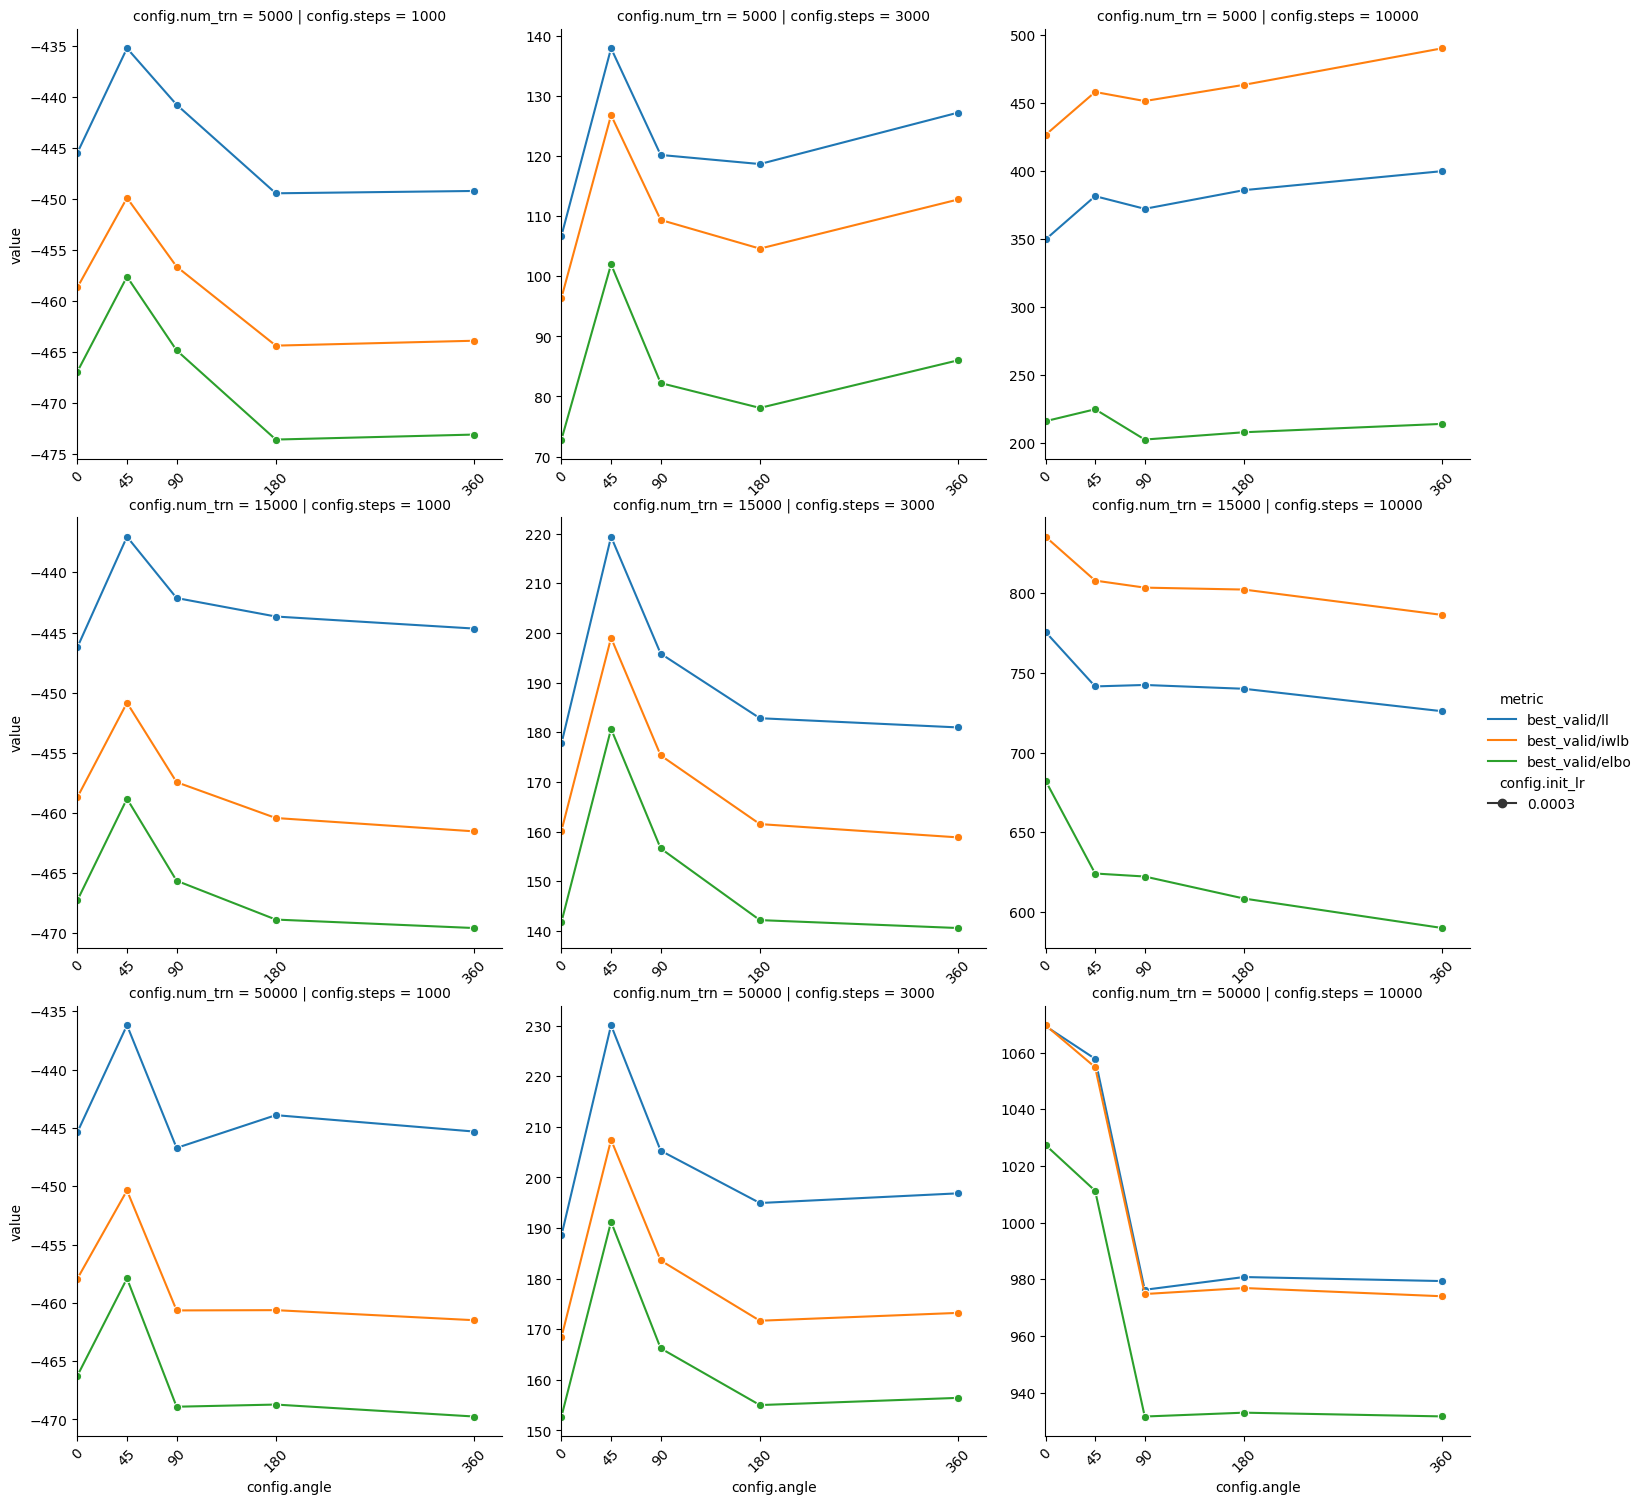

In [88]:
plot_df = df_filtered[[
    'best_valid/ll', 'best_valid/iwlb', 'best_valid/elbo',
    'config.angle', 'config.num_trn', 'config.steps', 'config.init_lr'
]]

# take only some settings
plot_df = plot_df[
    plot_df['config.init_lr'].isin([0.0003])
]

# pivot the data frame so that each of 'summary.best_val_ll', 'summary.best_val_iwlb', 'summary.best_val_elbo', 'summary.hais_mll'
# is a column, and the values are the corresponding values
plot_df = plot_df.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.steps', 'config.init_lr'],
    value_vars=['best_valid/ll', 'best_valid/iwlb', 'best_valid/elbo'],
    var_name='metric',
    value_name='value'
)

# remove the 'summary.' prefix from the metric names
# plot_df['metric'] = plot_df['metric'].str.replace('summary.', '')


g = sns.relplot(
    x="config.angle", y="value", hue="metric", row="config.num_trn", col='config.steps', style='config.init_lr',
    markers=True,
    # palette=sns.color_palette('viridis', as_cmap=True),
    kind="line",
    facet_kws=dict(sharey=False, sharex=False),
    data=plot_df
)
# g.set_axis_labels('Rotation angle', 'Best validation log-likelihood')
# g.set_titles('Total steps: {col_name}')
for axs in g.axes:
    for ax in axs:
        # ax.set(xscale="symlog")
        ax.set_xticks(plot_df['config.angle'].unique())
        ax.set_xticklabels(plot_df['config.angle'].unique(), rotation=45)
        ax.set_xlim(-.1, 385)
plt.show()